In [1]:
import pandas as pd 
import numpy as np
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use(plt.style.available[24])
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the xtick labels
plt.rc('ytick', labelsize=12)     # fontsize of the ytick labels (also applies to colorbar)
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title
plt.rc('lines', linewidth=2)     # line width
plt.rc('figure', figsize=(6, 5)) # figure size
plt.rc('axes', axisbelow=True)
import sys
sys.path.append('../datasets')
from fuchs_model import calc_laser_energy

In [2]:
df = pd.read_hdf('../datasets/fuchs_v5_0_seed-2_train_1525000_noise_0_threeEns_.h5', key='df').fillna(0)
df.head()

,Intensity,Pulse Duration,Target Thickness,Spot Size,Focal Distance,Contrast,Max Proton Energy,Total Proton Energy,Avg Proton Energy,Max Exact Energy,Total Exact Energy,Avg Exact Energy,Laser Energy,Conversion Efficiency
0,1.000000e+18,40.0,0.5,1.5,-30.0,1.000000e-07,0.232522,3.088778e+07,0.038089,0.232522,3.088778e+07,0.038089,1.370048,0.003612
1,1.000000e+18,40.0,0.5,1.5,-30.0,1.183673e-07,0.220504,2.806581e+07,0.036870,0.220504,2.806581e+07,0.036870,1.366207,0.003291
2,1.000000e+18,40.0,0.5,1.5,-30.0,1.367347e-07,0.210142,2.574132e+07,0.035780,0.210142,2.574132e+07,0.035780,1.362653,0.003026
3,1.000000e+18,40.0,0.5,1.5,-30.0,1.551020e-07,0.201052,2.378342e+07,0.034792,0.201052,2.378342e+07,0.034792,1.359332,0.002803
4,1.000000e+18,40.0,0.5,1.5,-30.0,1.734694e-07,0.192968,2.210551e+07,0.033888,0.192968,2.210551e+07,0.033888,1.356202,0.002611


In [3]:
df1 = df[(np.abs(df['Contrast']) < 1.001e-7) & (df['Intensity'] > 9.999e18)]
print(df1.shape)

(610, 14)


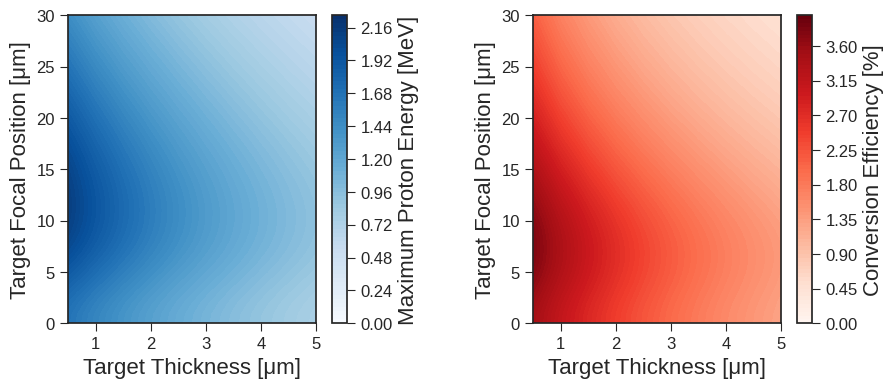

In [4]:
X = df1['Target Thickness'].values.reshape(61, 10)
Y = df1['Focal Distance'].values.reshape(61, 10)
Z1 = df1['Max Proton Energy'].values.reshape(61, 10)
Z2 = df1['Conversion Efficiency'].values.reshape(61, 10) * 100
fig, ax = plt.subplots(figsize=(10, 4), ncols = 2)
cax1 = ax[0].contourf(X, Y, Z1, cmap='Blues', levels=np.linspace(0, 2.25, 76))
cax2 = ax[1].contourf(X, Y, Z2, cmap='Reds', levels = np.linspace(0, 4, 81))
for i in range(2):
    ax[i].set_ylim(0, 30)
    ax[i].set_xlabel('Target Thickness [μm]')
    ax[i].set_ylabel('Target Focal Position [μm]')
    ax[i].set_xticks(np.arange(1, 5.1, 1))

cbar1 = fig.colorbar(cax1)
cbar2 = fig.colorbar(cax2)
cbar1.set_label('Maximum Proton Energy [MeV]')
cbar2.set_label('Conversion Efficiency [%]')
fig.subplots_adjust(wspace=0.5)
fig.savefig('plots/energy_efficiency.eps', format='eps', bbox_inches='tight')

In [8]:
desired_cutoff = 1
betas = [0, 0.25, 0.5, 0.75, 1]
levels = [np.linspace(-3.75, 0, 51), 
            np.linspace(-2.5, 0, 51), 
            np.linspace(-1.2, 0.2, 51), 
            np.linspace(-0.35, 0.3, 51), 
            np.linspace(0, 1.35, 51)]
def obj(df, desired_cutoff_energy = 1, beta = 0):
    cutoff_energy = df['Max Proton Energy'].values
    total_energy = df['Total Proton Energy'].values
    laser_energy_mev = calc_laser_energy(df['Intensity'].values * 1e4, 1.5e-6, 40e-15) / (1.609e-13) # Convert to MeV
    conversion_efficiency = total_energy / laser_energy_mev * 100
    return beta * np.abs(cutoff_energy - desired_cutoff_energy) + (1 - beta) * (-conversion_efficiency)

OBJs = [obj(df1, beta = beta, desired_cutoff_energy = desired_cutoff).reshape(61, 10) for beta in betas]
fig, ax = plt.subplots(figsize=(10, 8), nrows=2, ncols=2)
caxs = np.empty(shape=(2, 2), dtype=object)
cbars = np.empty(shape=(2, 2), dtype=object)
for i in range(2):
    for j in range(2):
        caxs[i, j] = ax[i, j].contourf(X, Y, OBJs[1 + i * 2 + j], cmap='jet', levels=levels[1 + i * 2 + j])
        cbars[i, j] = fig.colorbar(caxs[i, j], ax=ax[i, j])

for i in range(2):
    for j in range(2):
        ax[1, j].set_xlabel('Target Thickness [μm]')
        ax[i, j].text(0.6, 28, r'$\beta = $' + str(betas[1 + i * 2 + j]), fontsize=16, color='black')
        ax[i, j].set_ylim(0, 30)
        cbars[i, 1].set_label('Objective Function')
        ax[i, 0].set_ylabel('Target Focal Position [μm]')

fig.savefig('plots/obj_function.eps', format='eps', bbox_inches='tight')

#ax[0].set_ylabel('Target Focal Position [μm]')
#cbar1.set_label('Objective Function')
#cbar2.set_label('Objective Function')
# cbar3.set_label('Objective Function')
# fig.subplots_adjust(wspace=0.3)

In [9]:
np.save('results/FUCHS_Xgrid.npy', X)
np.save('results/FUCHS_Ygrid.npy', Y)
for i, beta in enumerate(betas_all):
    np.save(f'results/FUCHS_beta={beta}_cutoff={desired_cutoff}.npy', OBJs[i])

In [150]:
focus = 10
thickness = 0.5
df2 = df[(df['Focal Distance'] < focus+1e-3) & (df['Focal Distance'] > focus-1e-3)  & (df['Target Thickness'] == thickness)]
print(df2.shape)

(2500, 14)


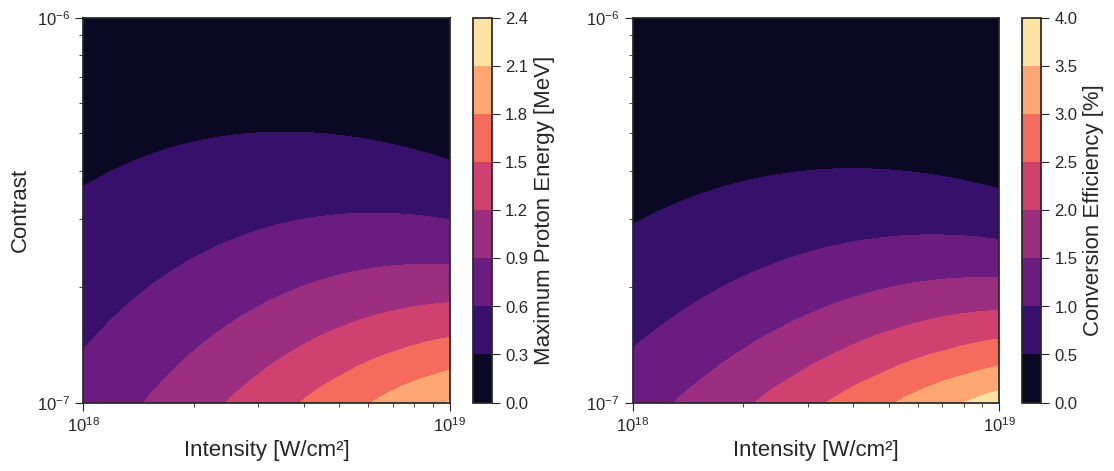

In [151]:
X = df2['Intensity'].values.reshape(50, 50)
Y = df2['Contrast'].values.reshape(50, 50)
Z1 = df2['Max Proton Energy'].values.reshape(50, 50)
Z2 = df2['Conversion Efficiency'].values.reshape(50, 50) * 100
fig, ax = plt.subplots(figsize=(13, 5), ncols = 2)
cax1 = ax[0].contourf(X, Y, Z1, cmap='magma')
cax2 = ax[1].contourf(X, Y, Z2, cmap='magma')
for i in range(2):
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_xlabel('Intensity [W/cm²]')
ax[0].set_ylabel('Contrast')

cbar1 = fig.colorbar(cax1)
cbar2 = fig.colorbar(cax2)
cbar1.set_label('Maximum Proton Energy [MeV]')
cbar2.set_label('Conversion Efficiency [%]')